In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt

from wind_dir_classifier import load_netcdf
from models import data_prep, compile_and_fit, evaluate
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import Reshape
from keras.layers import TimeDistributed

In [2]:
# loading needed data
df = load_netcdf('C:/Studia/maciej-romanski/data/ERA5_single_location')
df = df.drop(labels=['windspeed_10', 'windspeed_100'], axis=1)

c:\Studia\maciej-romanski\wind_dir_classifier.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(netCDF2df(path+'/'+filename),ignore_index=True)


In [3]:
df

,t2m,d2m,msl,tp,u10,v10,u100,v100,ssrd,Date Time
0,262.714033,259.900872,103298.015394,0.000000,0.637819,-2.406421,0.903655,-3.709255,0.0,1950-01-01 00:00:00
1,260.695745,258.184905,103401.866726,0.000000,0.922727,-1.589199,1.500161,-3.410746,0.0,1950-01-01 01:00:00
2,260.195929,257.699157,103434.928307,0.000000,1.599350,-2.048641,1.843544,-3.019235,0.0,1950-01-01 02:00:00
3,259.350219,256.948053,103418.318422,0.000000,1.825593,-1.757785,2.032306,-2.403842,0.0,1950-01-01 03:00:00
4,258.763065,256.665744,103419.030274,0.000000,1.989750,-1.709849,2.543653,-2.705351,0.0,1950-01-01 04:00:00
...,...,...,...,...,...,...,...,...,...,...
622387,274.643734,274.172750,100974.912154,0.000006,-0.439706,-0.680139,-0.930238,-1.553409,0.0,2020-12-31 19:00:00
622388,274.719036,274.144356,100973.148236,0.000005,-0.410773,-0.765752,-0.861213,-1.216175,0.0,2020-12-31 20:00:00
622389,274.310849,273.971416,100980.668096,0.000003,-0.360798,-0.685017,-0.729079,-1.110241,0.0,2020-12-31 21:00:00
622390,273.450250,273.092257,100972.962561,0.000002,-0.078309,-0.644528,-0.032517,-0.560758,0.0,2020-12-31 22:00:00


In [4]:
X_train, y_train, X_test, y_test, scaler_y_u100 = data_prep(df, 2012, 2019, 2020, 2020, 24, 1, y_featurename='u100')

# defining models
model_u100 = Sequential([
    Dense(units=200, activation='relu', input_shape=(24, X_train.shape[2])),
    Dropout(0.2),
    Dense(units=200, activation='relu'),
    Dropout(0.2),
    Dense(units=200, activation='relu'),
    Dropout(0.2),
    Dense(1),
    Reshape([1,24]),
    Dense(1),
    Reshape([1])
])

compile_and_fit(model_u100, X_train, y_train)

X_train, y_train, X_test, y_test, scaler_y_v100 = data_prep(df, 2012, 2019, 2020, 2020, 24, 1, y_featurename='v100')

# defining models
model_v100 = Sequential([
    Dense(units=200, activation='relu', input_shape=(24, X_train.shape[2])),
    Dropout(0.2),
    Dense(units=200, activation='relu'),
    Dropout(0.2),
    Dense(units=200, activation='relu'),
    Dropout(0.2),
    Dense(1),
    Reshape([1,24]),
    Dense(1),
    Reshape([1])
])

compile_and_fit(model_v100, X_train, y_train)

Epoch 1/20
2191/2191 [==============================] - 15s 6ms/step - loss: 0.0055
Epoch 2/20
2191/2191 [==============================] - 14s 7ms/step - loss: 0.0019
Epoch 3/20
2191/2191 [==============================] - 14s 6ms/step - loss: 0.0012
Epoch 4/20
2191/2191 [==============================] - 14s 6ms/step - loss: 9.9553e-04
Epoch 5/20
2191/2191 [==============================] - 14s 6ms/step - loss: 8.9790e-04
Epoch 6/20
2191/2191 [==============================] - 14s 6ms/step - loss: 8.3058e-04
Epoch 7/20
2191/2191 [==============================] - 15s 7ms/step - loss: 7.8803e-04
Epoch 8/20
2191/2191 [==============================] - 15s 7ms/step - loss: 7.5573e-04
Epoch 9/20
2191/2191 [==============================] - 15s 7ms/step - loss: 7.4251e-04
Epoch 10/20
2191/2191 [==============================] - 15s 7ms/step - loss: 7.2825e-04
Epoch 11/20
2191/2191 [==============================] - 15s 7ms/step - loss: 7.1332e-04
Epoch 12/20
2191/2191 [===================

In [5]:
u_100 = model_u100.predict(X_test)
v_100 = model_v100.predict(X_test)
u_100 = scaler_y_u100.inverse_transform(u_100)
v_100 = scaler_y_v100.inverse_transform(v_100)


274/274 [==============================] - 1s 2ms/step


In [6]:
directions_pred = np.arctan2(v_100, u_100)

In [7]:
df['ws_100'] = np.sqrt(np.square(df['u100']) + np.square(df['v100']))
df['wd_100'] = np.arctan2(df['v100'], df['u100'])
df['ws_10'] = np.sqrt(np.square(df['u10']) + np.square(df['v10']))
df['wd_10'] = np.arctan2(df['v10'], df['u10'])
df = df.drop(labels=['v10', 'u10', 'v100', 'u100'], axis=1)

In [8]:
df

,t2m,d2m,msl,tp,ssrd,Date Time,ws_100,wd_100,ws_10,wd_10
0,262.714033,259.900872,103298.015394,0.000000,0.0,1950-01-01 00:00:00,3.817744,-1.331830,2.489513,-1.311705
1,260.695745,258.184905,103401.866726,0.000000,0.0,1950-01-01 01:00:00,3.726080,-1.156429,1.837656,-1.044746
2,260.195929,257.699157,103434.928307,0.000000,0.0,1950-01-01 02:00:00,3.537574,-1.022619,2.599009,-0.907942
3,259.350219,256.948053,103418.318422,0.000000,0.0,1950-01-01 03:00:00,3.147813,-0.868955,2.534284,-0.766478
4,258.763065,256.665744,103419.030274,0.000000,0.0,1950-01-01 04:00:00,3.713367,-0.816194,2.623488,-0.709885
...,...,...,...,...,...,...,...,...,...,...
622387,274.643734,274.172750,100974.912154,0.000006,0.0,2020-12-31 19:00:00,1.810642,-2.110360,0.809895,-2.144703
622388,274.719036,274.144356,100973.148236,0.000005,0.0,2020-12-31 20:00:00,1.490224,-2.186959,0.868971,-2.063162
622389,274.310849,273.971416,100980.668096,0.000003,0.0,2020-12-31 21:00:00,1.328229,-2.151857,0.774225,-2.055575
622390,273.450250,273.092257,100972.962561,0.000002,0.0,2020-12-31 22:00:00,0.561700,-1.628719,0.649268,-1.691702


In [20]:
X_train, y_train, X_test, y_test, scaler_y_wd100 = data_prep(df, 2012, 2019, 2020, 2020, 24, 1, y_featurename='wd_100')

# defining models
model_wd100 = Sequential([
    Dense(units=200, activation='relu', input_shape=(24, X_train.shape[2])),
    # Dropout(0.2),
    Dense(units=200, activation='relu'),
    # Dropout(0.2),
    Dense(units=200, activation='relu'),
    # Dropout(0.2),
    Dense(1),
    Reshape([1,24]),
    Dense(1),
    Reshape([1])
])

compile_and_fit(model_wd100, X_train, y_train)
wd_100 = model_wd100.predict(X_test)
wd_100 = scaler_y_wd100.inverse_transform(wd_100)
directions_true = scaler_y_wd100.inverse_transform(y_test)


Epoch 1/20
2191/2191 [==============================] - 9s 4ms/step - loss: 0.0334
Epoch 2/20
2191/2191 [==============================] - 8s 4ms/step - loss: 0.0221
Epoch 3/20
2191/2191 [==============================] - 8s 4ms/step - loss: 0.0198
Epoch 4/20
2191/2191 [==============================] - 8s 4ms/step - loss: 0.0187
Epoch 5/20
2191/2191 [==============================] - 8s 4ms/step - loss: 0.0181
Epoch 6/20
2191/2191 [==============================] - 8s 4ms/step - loss: 0.0177
Epoch 7/20
2191/2191 [==============================] - 8s 4ms/step - loss: 0.0173
Epoch 8/20
2191/2191 [==============================] - 8s 4ms/step - loss: 0.0171
Epoch 9/20
2191/2191 [==============================] - 8s 4ms/step - loss: 0.0170
Epoch 10/20
2191/2191 [==============================] - 8s 4ms/step - loss: 0.0168
Epoch 11/20
2191/2191 [==============================] - 8s 4ms/step - loss: 0.0168
Epoch 12/20
2191/2191 [==============================] - 9s 4ms/step - loss: 0.0167
E

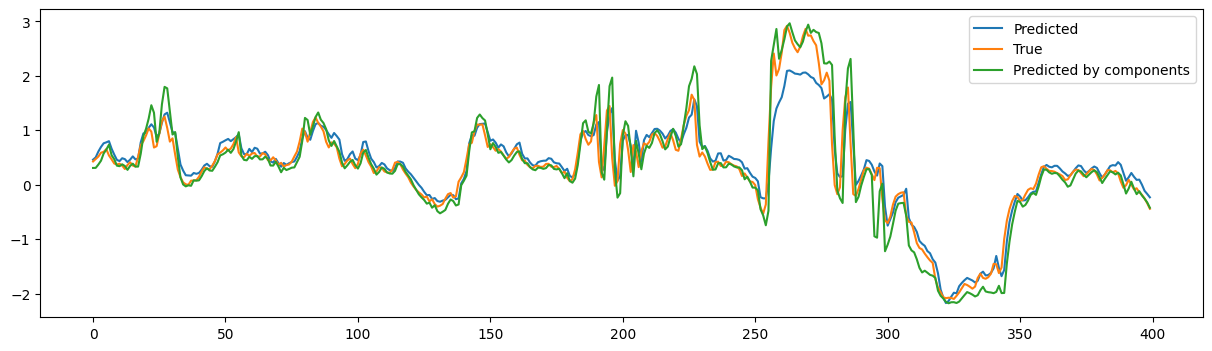

In [11]:
# mean = (wd_100 + directions_pred) / 2
plt.figure(figsize=(15,4))
plt.plot(wd_100[100:500])
plt.plot(directions_true[100:500])
plt.plot(directions_pred[100:500])
# plt.plot(mean[100:500])
plt.legend(['Predicted', 'True', 'Predicted by components'])
plt.show()

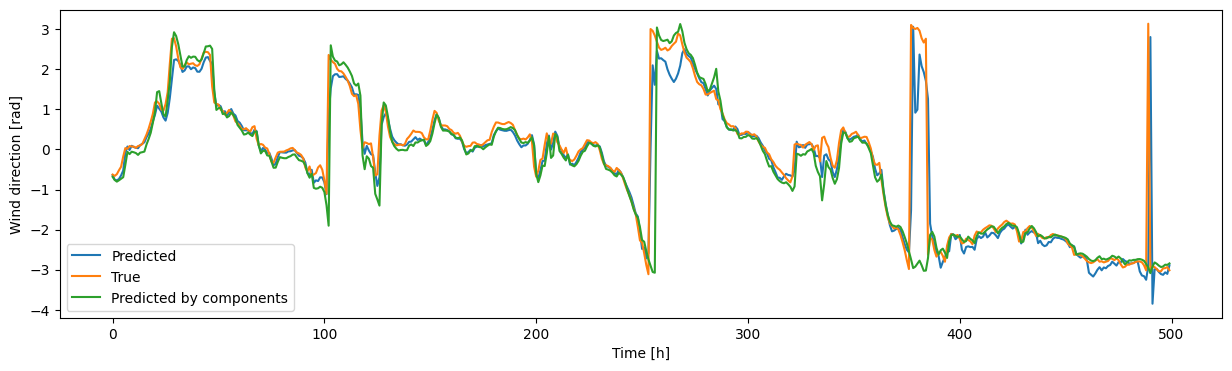

In [26]:
# mean = (wd_100 + directions_pred) / 2
plt.figure(figsize=(15,4))
plt.plot(wd_100[1500:2000])
plt.plot(directions_true[1500:2000])
plt.plot(directions_pred[1500:2000])
# plt.plot(mean[100:500])
plt.legend(['Predicted', 'True', 'Predicted by components'])
plt.xlabel("Time [h]")
plt.ylabel("Wind direction [rad]")
plt.show()

In [22]:
rmse_by_comp = sqrt(np.square((directions_true-directions_pred+np.pi)%(2*np.pi)-np.pi).mean())
rmse_direct = sqrt(np.square((directions_true-wd_100+np.pi)%(2*np.pi)-np.pi).mean())

In [23]:
print(rmse_by_comp, rmse_by_comp*180/np.pi)
print(rmse_direct, rmse_direct*180/np.pi)

0.4341515827416012 24.8750533600185
0.5554454104747094 31.82467777011246


In [24]:
from sklearn.metrics import mean_squared_error
rmse_by_comp = sqrt(mean_squared_error(directions_true, directions_pred))
rmse_direct = sqrt(mean_squared_error(directions_true, wd_100))

In [25]:
print(rmse_by_comp, rmse_by_comp*180/np.pi)
print(rmse_direct, rmse_direct*180/np.pi)

1.3079167760383756 74.93811122135624
0.7862185195623571 45.04700294594681


In [62]:
rmse_mean = sqrt(np.square((directions_true-mean+np.pi)%(2*np.pi)-np.pi).mean())

In [63]:
rmse_mean

0.4696100536063361